# Predicting Agua Potabilization

Data source: 
- Training: `data-sources/clouds/clouds_train/`
- Testing : `data-sources/clouds/clouds_test/`

Predicting: 
- cirriform clouds      : 0, 
- clear sky             : 1,
- cumulonimbus clouds   : 2,
- cumulus clouds        : 3,
- high cumuliform clouds: 4,
- stratiform clouds     : 5,
- stratocumulus clouds  : 6

## 1. Prepare environment

In [1]:
# Importing libraries
import expectexception
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

import torch
import torch.nn as nn
import torch.optim as optim

from environment import prepare_environment

from pprint import pprint
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from typing import Tuple

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as Transforms
from torchvision.datasets import ImageFolder
from torchmetrics import Precision, Recall

In [2]:
# Global variables
SEED = 42

DATASET_CLOUD_TRAIN = "data-sources/clouds/clouds_train/"
DATASET_CLOUD_TEST = "data-sources/clouds/clouds_test/"

MODEL_CLOUD_CLASSIFIER = "artifacts/cloudclassifier.pth"

In [3]:
# Check if your GPU driver and CUDA is enabled and accessible by PyTorch
print(torch.__version__)
print('Cuda is available?', torch.cuda.is_available())

device = torch.cuda.current_device()  # returns you the ID of your current device
print('Device:', torch.cuda.get_device_name(device))  # returns you the name of the device

# # Reviewing allocated memmory, it is 0 if there is nothing allocated
# cuda_memory = torch.cuda.memory_allocated(device)
# cuda_cache = torch.cuda.memory_reserved(device)
# print(f"""
# CUDA memory device: {cuda_memory}
# CUDA cache  device: {cuda_cache}
# """)

2.4.1+cu124
Cuda is available? True
Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU


In [4]:
# Global configuration
prepare_environment()

torch.set_printoptions(precision=10)

# Reproducibility
np.random.seed(SEED)
_ = torch.manual_seed(SEED)

### Utilities

In [5]:
class ImageDataSet(Dataset):
    """
    PyTorch Dataset extended to load the data images based on a given folder
    Assumptions:
    - The images are distributed by category/label, each category is represented by the subfolders 
      included in the root_dir.
    - Full transformation is made on trainning set, and only ToTensor and Resize are made to testing set. 
    """
    
    def __init__(self, root_dir:str, is_train_set:bool=True) -> None:
        super().__init__
        torch.manual_seed(SEED)
        
        if is_train_set:
            self.transform = Transforms.Compose([
                Transforms.RandomHorizontalFlip(),
                Transforms.RandomRotation(45),
                Transforms.RandomAutocontrast(),
                Transforms.ToTensor(),
                Transforms.Resize((64, 64))
            ])
        else:
            self.transform = Transforms.Compose([
                Transforms.ToTensor(),
                Transforms.Resize((64, 64))
            ])
        self.label_dict = {l: i for i, l in enumerate(sorted(os.listdir(DATASET_CLOUD_TRAIN)))}
        self.data = ImageFolder(root_dir, transform=self.transform,)

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, idx:int) -> Tuple[torch.Tensor, torch.Tensor]:
        return self.data[idx]

    @property
    def class_to_idx(self):
        return self.label_dict

In [6]:
# Build the binary classifier model
class ImageClassifierModel(nn.Module):
    """CNN model for image cloud classifier problems.
    """
    def __init__(self, num_classes:int, seed:int=SEED) -> None:
        super().__init__()
        torch.manual_seed(SEED)
        
        self.feature_extractor = nn.Sequential(           # Imagine input images 3 X 64 X 64 (channel, width, height)
            nn.Conv2d(3, 32, kernel_size=3, padding=1),   # Input channel=3, output channel=32 → 32 x 64 x 64
            nn.ELU(),                                     # No Changes → 32 x 64 x 64
            nn.MaxPool2d(kernel_size=2),                  # Divide image size by 2 → 32 x 32 x 32
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # Input channel=32, output channel=64 → 64 x 32 x 32
            nn.ELU(),                                     # No Changes → 64 x 32 x 32
            nn.MaxPool2d(kernel_size=2),                  # Divide image size by 2 → 64 x 16 x 16
            nn.Flatten(),                                 # Flatten image → 64 x 16 x 16
        )
        self.classifier = nn.Linear(64*16*16, num_classes)
        
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x

## 2. Review datasets

In [7]:
print('TRAIN DATASET:')
total = 0
for directory in os.listdir(DATASET_CLOUD_TRAIN):
    num_files = sum([len(f) for _, _, f in os.walk(DATASET_CLOUD_TRAIN + directory)])
    print(f'- {directory}: {num_files}')
    total += num_files
print('Total images:', total)

TRAIN DATASET:
- cirriform clouds: 66
- clear sky: 60
- cumulonimbus clouds: 14
- cumulus clouds: 91
- high cumuliform clouds: 133
- stratiform clouds: 49
- stratocumulus clouds: 61
Total images: 474


In [8]:
print('TEST DATASET:')
total = 0
for directory in os.listdir(DATASET_CLOUD_TEST):
    num_files = sum([len(f) for _, _, f in os.walk(DATASET_CLOUD_TEST + directory)])
    print(f'- {directory}: {num_files}')
    total += num_files
print('Total images:', total)

TEST DATASET:
- cirriform clouds: 77
- clear sky: 64
- cumulonimbus clouds: 11
- cumulus clouds: 120
- high cumuliform clouds: 103
- stratiform clouds: 40
- stratocumulus clouds: 71
Total images: 486


## 3. Get dataloader

In [9]:
# Get the dataset
dataset_train = ImageDataSet(DATASET_CLOUD_TRAIN)
dataset_test = ImageDataSet(DATASET_CLOUD_TEST)
print(f"""
Train dataset size: {len(dataset_train)}
Test dataset size: {len(dataset_test)}
""")

# Create a DataLoader based on dataset_train
dataloader_train = DataLoader(dataset_train, batch_size=16, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=16, shuffle=True)

# Labels
print('Labels in training set')
pprint(dataset_train.class_to_idx)
print('\nLabels in testing set:')
pprint(dataset_test.class_to_idx)


Train dataset size: 474
Test dataset size: 486

Labels in training set
{'cirriform clouds': 0,
 'clear sky': 1,
 'cumulonimbus clouds': 2,
 'cumulus clouds': 3,
 'high cumuliform clouds': 4,
 'stratiform clouds': 5,
 'stratocumulus clouds': 6}

Labels in testing set:
{'cirriform clouds': 0,
 'clear sky': 1,
 'cumulonimbus clouds': 2,
 'cumulus clouds': 3,
 'high cumuliform clouds': 4,
 'stratiform clouds': 5,
 'stratocumulus clouds': 6}


Data point: torch.Size([3, 64, 64])
Image reshaped torch.Size([64, 64, 3])


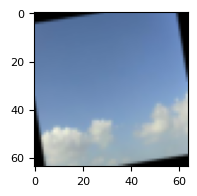

In [10]:
# Reviewing the dataset
image, label = next(iter(dataloader_train))
image = image[0]
print("Data point:", image.shape)
image = image.squeeze()
image = image.permute(1, 2, 0)
print("Image reshaped", image.shape)
fig = plt.figure(figsize=(2, 2))
plt.imshow(image)
plt.show()

## 4. Build the model

In [11]:
# Build the model
model = ImageClassifierModel(num_classes=7)
print(f"Are we using GPU? {next(model.parameters()).is_cuda}\n")
print(model)

# Set the criterion and teh optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # weight_decay=1e-4

Are we using GPU? False

ImageClassifierModel(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ELU(alpha=1.0)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ELU(alpha=1.0)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (classifier): Linear(in_features=16384, out_features=7, bias=True)
)


## 5. Train the model

In [12]:
# Train the model
losses = []
# accuracies = []

epochs = 100
model.train()
for epoch in range(epochs):
    running_loss = 0.0
    
    for X, y in dataloader_train:                   # Get feature and target from the data loader
        optimizer.zero_grad()                       # zero the parameter gradients
        y_out = model(X)                            # Run a forward pass
        loss = criterion(y_out, y)                  # Compute loss
        loss.backward()                             # Backward pass
        optimizer.step()                            # Optimization
        running_loss += loss.item()

    epoch_loss = running_loss / len(dataloader_train)
    losses.append(epoch_loss)                       # Record the loss per epoch
    if (epoch + 1) % 10 == 0:                       # Print the loss every 10 epochs
        print(f"Epoch {epoch+1}, Loss: {epoch_loss:.6f}")

Epoch 10, Loss: 1.071770
Epoch 20, Loss: 0.847502
Epoch 30, Loss: 0.702454
Epoch 40, Loss: 0.606812
Epoch 50, Loss: 0.605388
Epoch 60, Loss: 0.473880
Epoch 70, Loss: 0.420049
Epoch 80, Loss: 0.424012
Epoch 90, Loss: 0.359085
Epoch 100, Loss: 0.368359


In [13]:
print(f"""
y_out:
{y_out}

y:
{y}
""")


y_out:
tensor([[ 1.9669567347e+00,  1.1442829132e+01, -1.5839949608e+01,
         -6.6670622826e+00, -2.2025284171e-01,  8.9162158966e+00,
         -2.5299174786e+00],
        [ 2.2610688210e+00, -1.2083152771e+01, -1.4046504021e+01,
         -7.8557884693e-01,  5.7696056366e+00, -3.5052292347e+00,
          3.1750793457e+00],
        [ 3.6840753555e+00, -1.3759031296e+01, -1.3133908272e+01,
          2.5226242542e+00,  4.7837395668e+00, -5.6122431755e+00,
          2.6174921989e+00],
        [ 2.3782448769e+00, -2.5843355656e+00, -1.1331641197e+01,
         -2.0438492298e-01,  2.4177362919e+00,  3.8724222183e+00,
         -1.9617213011e+00],
        [ 2.7829623222e+00, -3.2345478535e+00, -1.2730266571e+01,
         -2.3093800545e+00,  6.2166714668e-01,  7.2564730644e+00,
          3.1983859837e-02],
        [ 6.0794281960e+00, -1.4399532318e+01, -3.3303887844e+00,
          2.9865410328e+00,  6.5670523643e+00, -1.1757493019e+01,
         -3.8704698086e+00],
        [-3.7782473564e+00

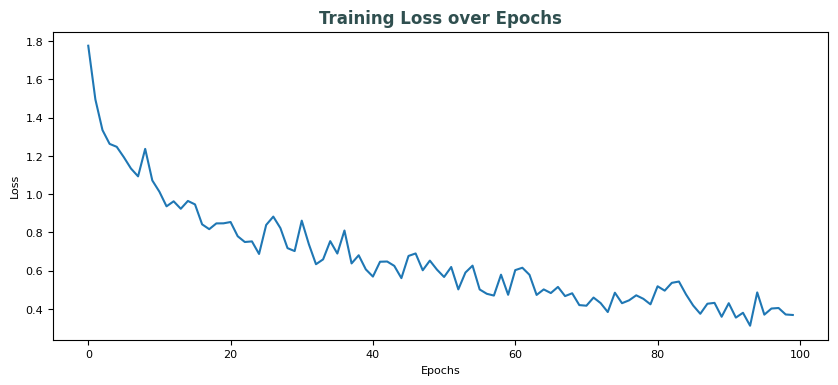

In [14]:
# Visualizing the loss in training set
fig = plt.figure(figsize=(10, 4))
plt.plot(range(epochs), losses)
plt.title("Training Loss over Epochs")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [15]:
# Saving the model
torch.save(model, MODEL_CLOUD_CLASSIFIER)

## 6. Evaluate model

In [16]:
# Set the evaluation metrics
metric_precision = Precision(task="multiclass", num_classes=7, average=None)
metric_recall = Recall(task="multiclass", num_classes=7, average="macro")

# Evaluation loop
model.eval()
with torch.no_grad():
    for images, labels in dataloader_test:
        outputs = model(images)
        _, preds = torch.max(outputs, dim=1)
        metric_precision(preds, labels)
        metric_recall(preds, labels)
precision = metric_precision.compute()
recall = metric_recall.compute()

# Compute metrics
precision_per_class = {k: precision[v].item() for k, v in dataset_test.class_to_idx.items()}
print(f"Precision:")
pprint(precision_per_class)
print(f"Recall: {recall}")

Precision:
{'cirriform clouds': 0.6236559152603149,
 'clear sky': 0.96875,
 'cumulonimbus clouds': 0.4285714328289032,
 'cumulus clouds': 0.8181818127632141,
 'high cumuliform clouds': 0.5899280309677124,
 'stratiform clouds': 0.804347813129425,
 'stratocumulus clouds': 0.523809552192688}
Recall: 0.6997752785682678


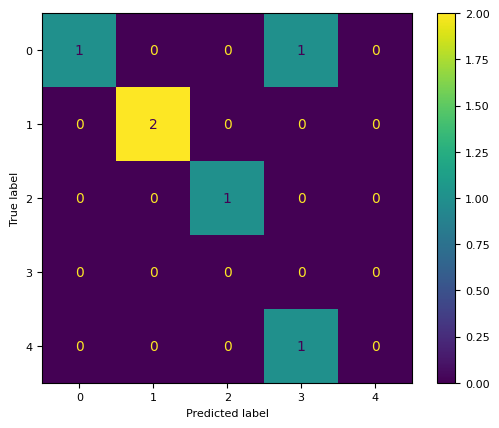

In [17]:
cm = confusion_matrix(labels.numpy(), preds.numpy())
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
_ = disp.plot()

In [18]:
pd.DataFrame({
    'y_true': labels.numpy(),
    'y_pred': preds.numpy(),
    'Accerted': ['True' 
                 if labels.numpy()[i] == preds.numpy()[i]
                 else ''
                 for i in range(len(labels))] 
})

,y_true,y_pred,Accerted
0,0,4,
1,1,1,True
2,1,1,True
3,0,0,True
4,3,3,True
5,6,4,


## 7. Close environment

In [19]:
# Reviewing allocated memmory, it is 0 if there is nothing allocated
cuda_memory = torch.cuda.memory_allocated(device)
cuda_cache = torch.cuda.memory_reserved(device)
print(f"""
CUDA memory device: {cuda_memory}
CUDA cache  device: {cuda_cache}
""")

# Free allocated memory
torch.cuda.empty_cache() 


CUDA memory device: 0
CUDA cache  device: 0



----------------------------------